# Spotter Buoys - Quality Control Analysis

## Import libs

In [36]:
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
idx = pd.IndexSlice

import psycopg2
from dotenv import load_dotenv

from scipy.stats import normaltest, circmean, skew

import matplotlib.pyplot as plt
import seaborn as sns

import pnboia_qc.pnboia_limits as pnboia_limits
from pnboia_qc.qc_checks import QCChecks

import pnboia_qc.pnboia_limits_tests as pnboia_limits_tests
from pnboia_qc.lims_gen import *

import os

load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

- Get data from Alcatrazes, Noronha, Abrolhos and Imbituba

In [3]:
# GET DATA FROM PROD DB
# connect to the old db
con = psycopg2.connect(
                        host=os.getenv('host_old'),
                        database=os.getenv('db_old'),
                        user=os.getenv('user_old'),
                        password=os.getenv('pswd_old'),
                        port=5432, #set as default
                      )

# create the cursor
cur = con.cursor()

# retrieve data as a dataframe
table = "remobs.spotter_general"
query = f"""SELECT * FROM {table} 
            WHERE buoy_id IN 
                (SELECT buoy_id FROM remobs.buoys  
                    WHERE name_buoy = 'Alcatrazes' 
                    OR name_buoy = 'Noronha' 
                    OR name_buoy = 'Imbituba' 
                    OR name_buoy = 'abrolhos');"""

spot_data = sqlio.read_sql_query(query, con)
spot_data.set_index('date_time',inplace=True)

cur.close()

con.close()


/home/remobs-dados/.pyenv/versions/3.8.12/envs/pnboia_qc/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
# Limits from pnboia_limits_tests.py
# Note that the range limit for spotters swvht was corrected (1 -> 19.9)
spotters_lims = pnboia_limits_tests.spotters

In [5]:
data_path = '/home/remobs-dados/PNBOIA/pnboia_qc/data'
os.chdir(data_path)

In [6]:
# DATA RAW
buoys_df_raw = pd.read_csv('pnboia_raw_data.csv',parse_dates=True)
buoys_df_raw['Datetime'] = pd.to_datetime(buoys_df_raw['Datetime'])
buoys_df_raw.rename(columns={'humi':'rh', # variables temporarily renamed to match QCChecks limits naming
                            'dewp':'dewpt',
                            'wtmp':'sst',
                            'cvel1':'cspd1',
                            'cvel2':'cspd2',
                            'cvel3':'cspd3',
                            'wvht':'swvht',
                            'wmax':'mxwvht',
                            'dpd':'tp',
                            'mwd':'wvdir',
                            'spred':'wvspread',
                            'arad':'srad'}, inplace=True)
buoys_df_raw.drop(columns=['lat','lon'],inplace=True)

names = {'cf':'cabofrio',
        'cf2':'cabofrio2',
        'fo':'fortaleza',
        'it':'itajai_0',
        'ni':'niteroi',
        'po':'porto_seguro', 
        're':'recife',
        'rg':'rio_grande', 
        'sa':'santos', 
        'vi':'vitoria'}


buoys_df_raw['buoy'] = buoys_df_raw['buoy'].replace(names)
buoys_df_raw.set_index(['buoy','Datetime'], inplace=True)

# Limits from pnboia_limits_tests.py
santos_lims = pnboia_limits_tests.santos

# santos data
santos_raw = buoys_df_raw.loc['santos']


# DATA SITE
buoys_df_site = pd.read_csv('pnboia_site_data.csv',parse_dates=['Datetime'],index_col=['buoy','Datetime'])
buoys_df_site.sort_index(inplace=True)

# Get buoys names
buoys_site = buoys_df_site.reset_index().loc[:,'buoy'].unique()

params_rename = {
                    'Cvel1':'cspd1',
                    'Cvel2':'cspd1',
                    'Cvel3':'cspd1',
                    'Dewp':'dewpt',
                    'Dpd':'tp',
                    'Gust':'gust',
                    'Humi':'rh',
                    'Pres':'pres',
                    'Pressao_Atm':'pres',
                    'Rad_Solar':'arad',
                    'Salinidade':'sss',
                    'Temp_Agua':'sst',
                    'Temp_Ar':'atmp',
                    'Umidade':'rh',
                    'Velocidade_Vento':'wspd',
                    'Wmax':'mxwvht',
                    'Wspd':'wspd1',
                    'Wtmp':'sst',
                    'Wvht':'swvht',
                    'dpd':'tp',
                    'wvht':'swvht',
                    'Direcao_Vento':'wdir',
                    'Wdir':'wdir1',
                    'Atmp':'atmp'
                 }

buoys_df_site.rename(columns=params_rename,inplace=True)

## Preliminary Filtering

In [7]:
spot_data.columns

Index(['buoy_id', 'id', 'lat', 'lon', 'sst', 'swvht', 'tp', 'mean_tp',
       'pk_dir', 'wvdir', 'pk_wvspread', 'wvspread', 'wspd', 'wdir',
       'sea_surface_id'],
      dtype='object')

In [8]:
spotters_lims.keys()

dict_keys(['range_limits', 'mis_value_limits', 'sigma_limits', 'outlier_limits', 'stuck_limits', 'continuity_limits', 'height'])

In [9]:
# filter data with
spot_filt = filter_data(data=spot_data,
                    limits=spotters_lims,
                    outlier_check=False,
                    t_continuity_check=False)

No mis_value_limit for wspd
No mis_value_limit for wdir
No mis_value_limit for sst
No mis_value_limit for swvht
No mis_value_limit for tp
No mis_value_limit for mean_tp
No mis_value_limit for pk_dir
No mis_value_limit for wvdir
mis_value_check done.
range_check done.


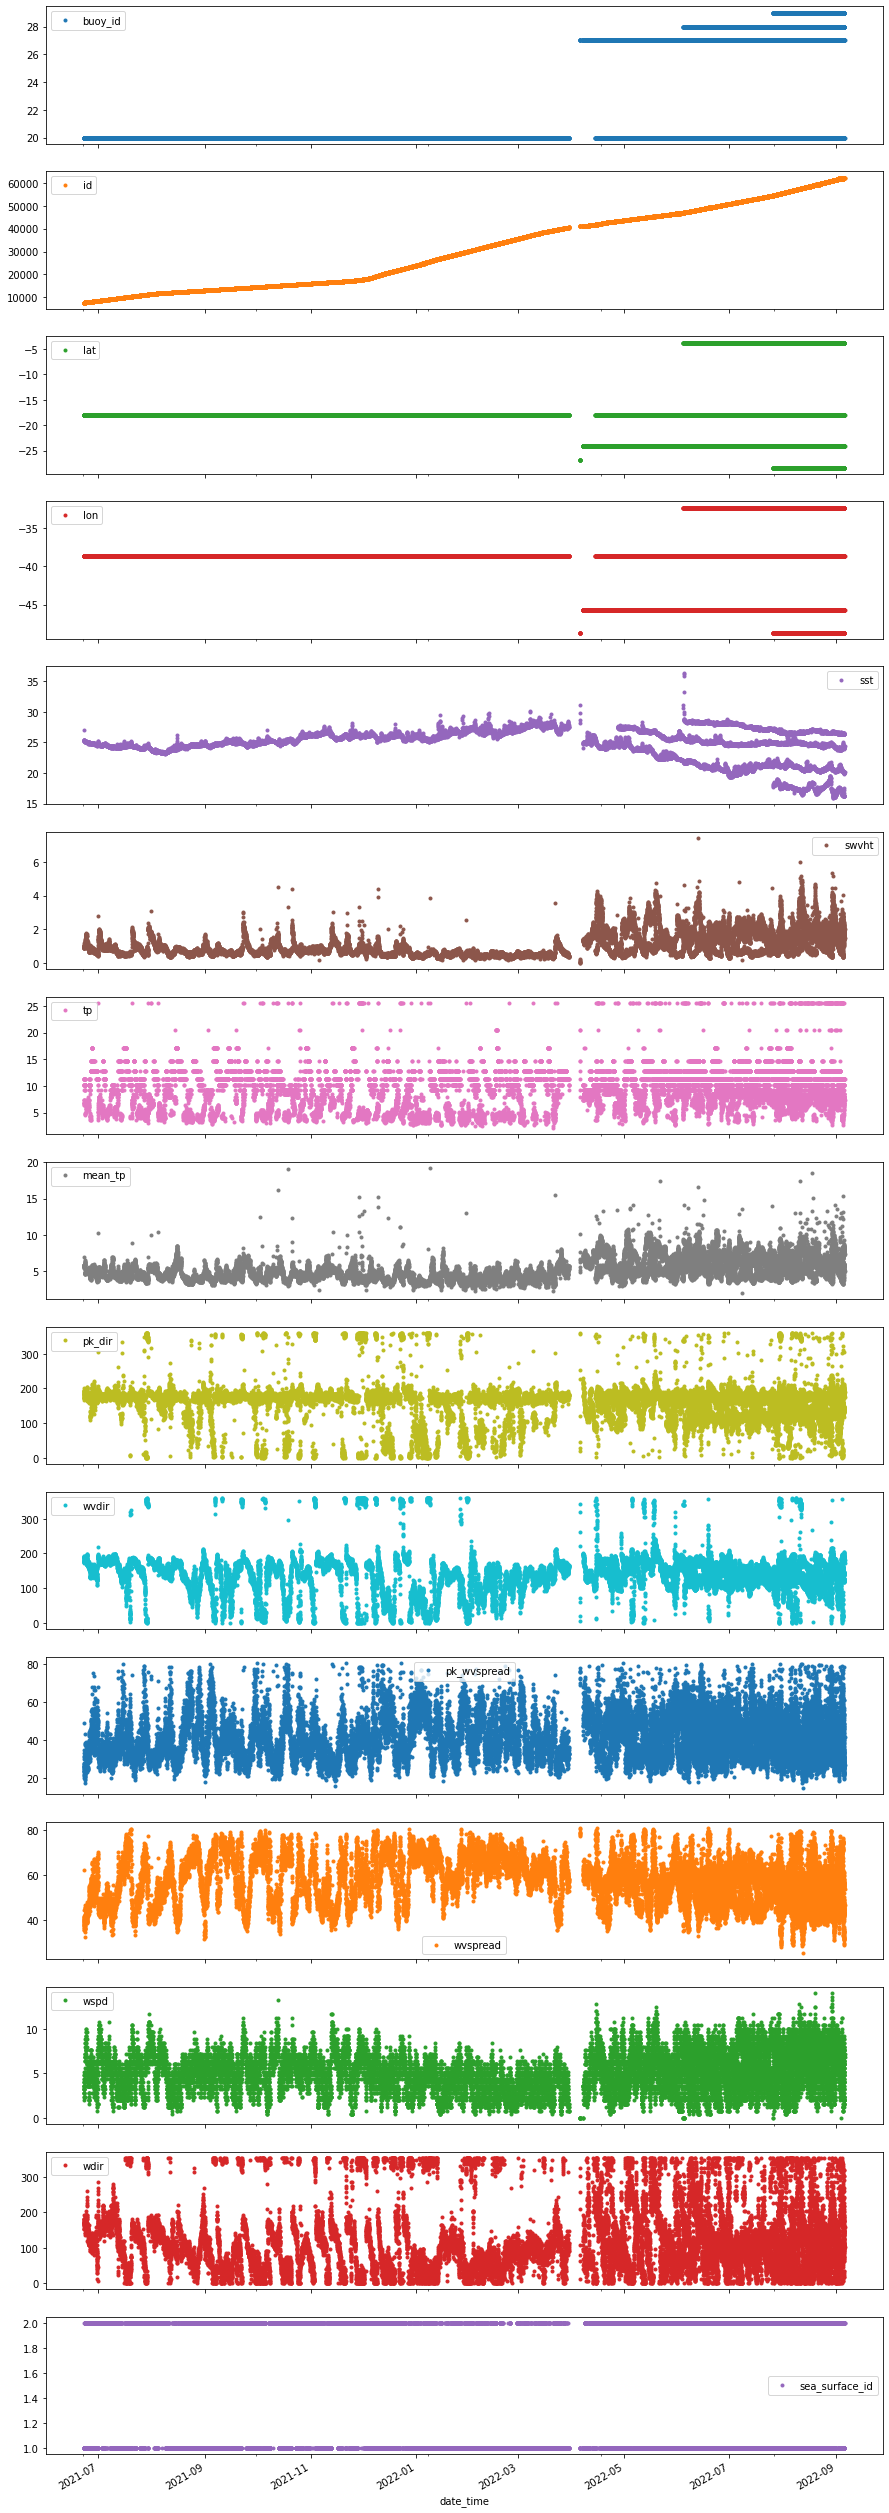

In [10]:
spot_data.plot(subplots=True, marker='.', ls='None', figsize=(15,50));

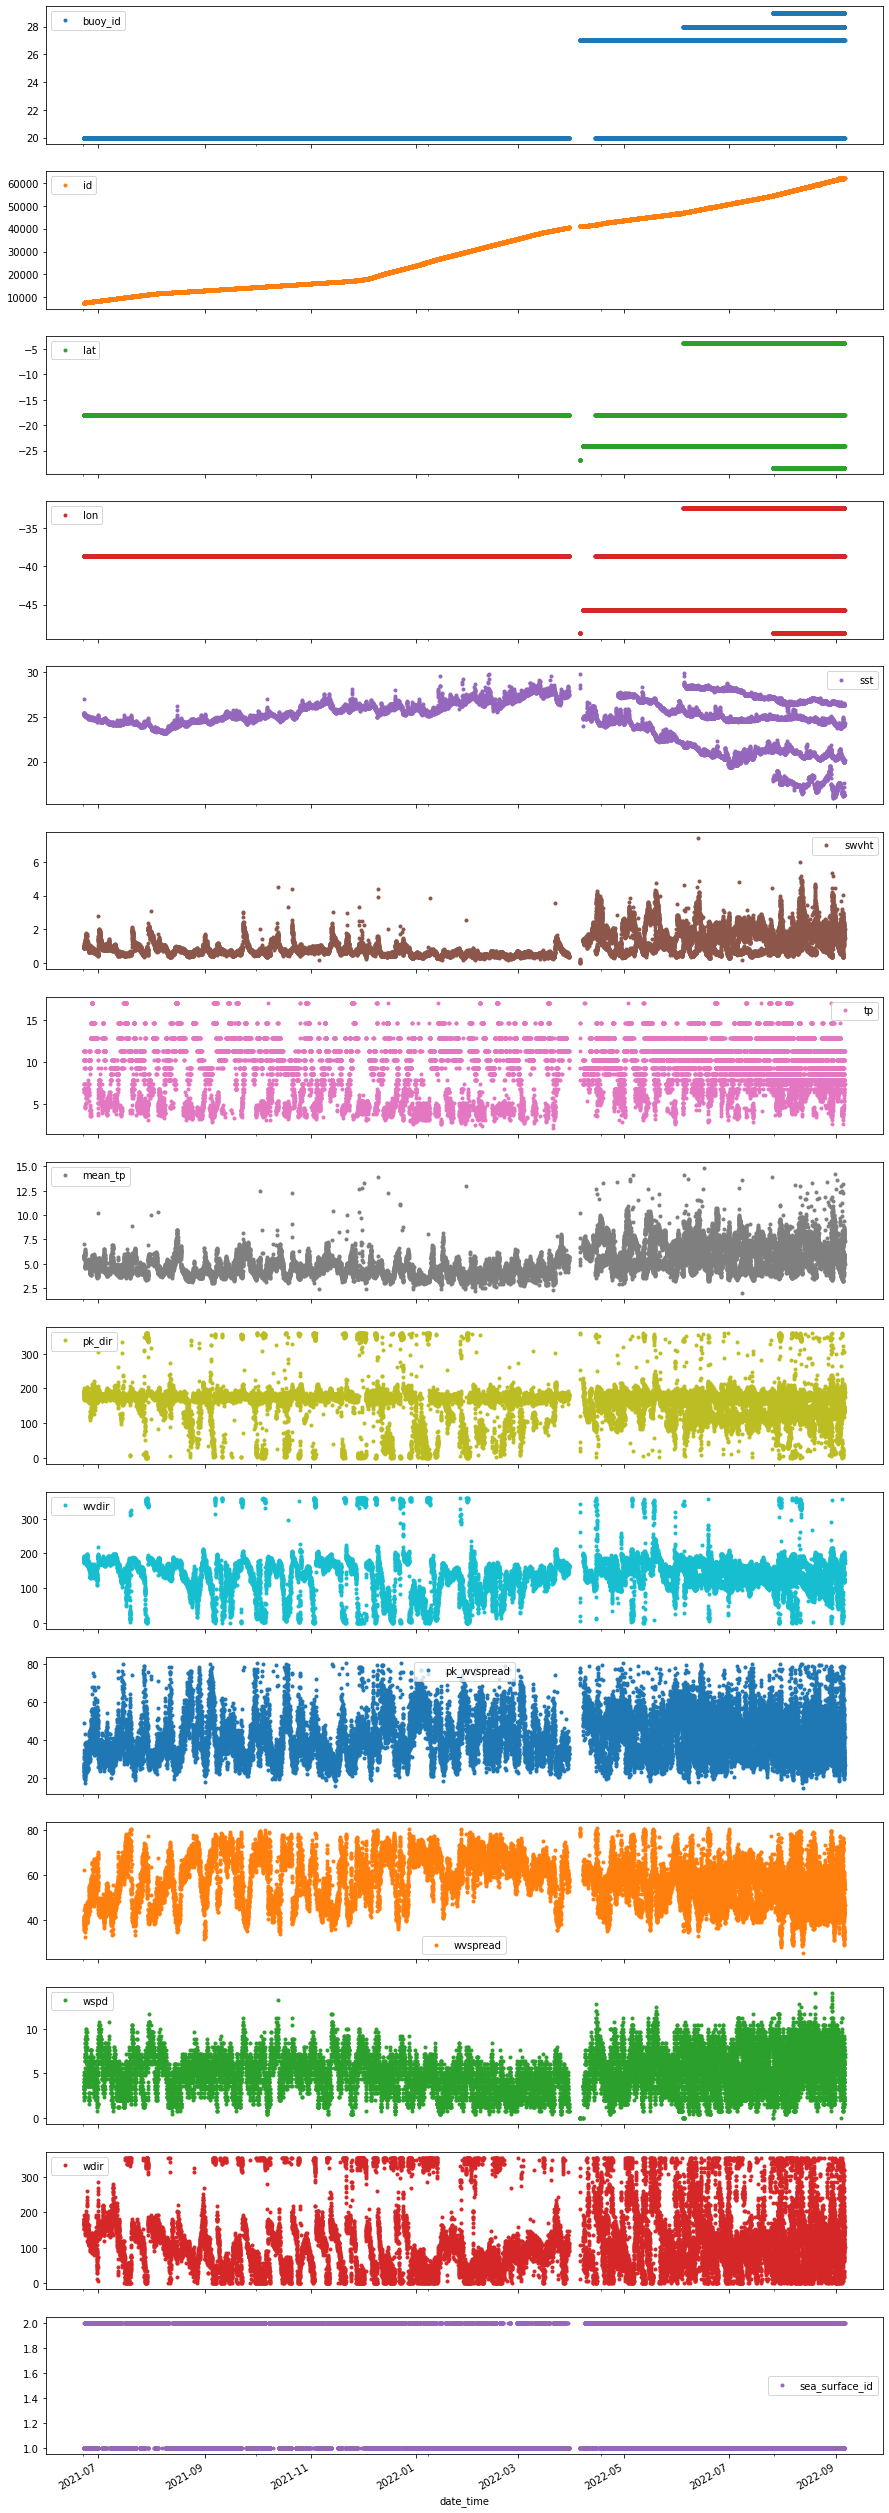

In [11]:
spot_filt.plot(subplots=True, marker='.', ls='None', figsize=(15,50));

## Statistical Analysis

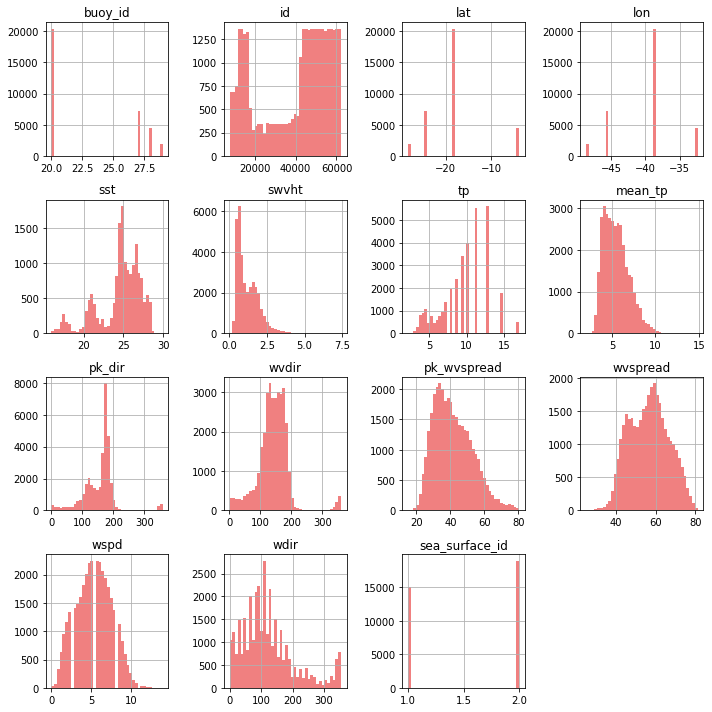

In [12]:
spot_filt.hist(bins=40, color='lightcoral', figsize=(10,10));
plt.tight_layout()

In [13]:
unw_cols = ['buoy_id','id','lat','lon','sea_surface_id']
raw_stats = spot_data.describe().loc[['mean','std','min','max']].round(2)
raw_stats.drop(columns=unw_cols)

,sst,swvht,tp,mean_tp,pk_dir,wvdir,pk_wvspread,wvspread,wspd,wdir
mean,24.61,1.21,9.76,5.51,155.74,140.59,41.63,56.65,5.33,122.03
std,2.69,0.70,3.39,1.48,51.69,51.49,11.33,9.81,2.22,82.82
min,15.94,0.03,2.12,2.02,0.07,0.10,14.86,25.08,0.00,0.00
max,36.40,7.42,25.60,19.24,360.00,360.00,80.62,81.03,14.00,354.00


In [14]:
filt_stats = spot_filt.describe().loc[['mean','std','min','max']].round(2)
filt_stats.drop(columns=unw_cols)

,sst,swvht,tp,mean_tp,pk_dir,wvdir,pk_wvspread,wvspread,wspd,wdir
mean,24.60,1.21,9.62,5.51,155.74,140.59,41.63,56.65,5.33,122.03
std,2.69,0.70,3.06,1.46,51.69,51.49,11.33,9.81,2.22,82.82
min,15.94,0.03,2.12,2.02,0.07,0.10,14.86,25.08,0.00,0.00
max,29.96,7.42,17.06,14.84,360.00,360.00,80.62,81.03,14.00,354.00


In [15]:
# Check diferences in raw data and filtered data statistics
raw_stats.compare(filt_stats)

sst            tp        mean_tp       
       self  other   self  other    self  other
mean  24.61  24.60   9.76   9.62     NaN    NaN
std     NaN    NaN   3.39   3.06    1.48   1.46
max   36.40  29.96  25.60  17.06   19.24  14.84

## Limits generation and data filtering

In [16]:
# Drop unwantetd columns for limit generation
spot_gen_lim_data = spot_filt.drop(columns=unw_cols)

In [17]:
# FACTOR 3
# Generated lims
spot_out_lims_df_3 = gen_outlier_lim(spot_gen_lim_data, buoy_name=None, std_factor=3).round(1)


# Generate lims dict
spot_out_lims_dict_3 = manual_outlier_lims('santos', spot_out_lims_df_3)


# filter data with
spot3 = filter_data(data=spot_gen_lim_data,
                    buoy=None,
                    limits=spotters_lims,
                    mis_value_check=False,
                    range_check=False,
                    t_continuity_check=False,
                    outlier_limits=spot_out_lims_dict_3)

outlier_check done.


In [18]:
# FACTOR 5
# Generated lims
spot_out_lims_df_5 = gen_outlier_lim(spot_gen_lim_data, buoy_name=None, std_factor=5).round(1)


# Generate lims dict
spot_out_lims_dict_5 = manual_outlier_lims('santos', spot_out_lims_df_5)


# filter data with
spot1 = filter_data(data=spot_gen_lim_data,
                    buoy=None,
                    limits=spotters_lims,
                    mis_value_check=False,
                    range_check=False,
                    t_continuity_check=False,
                    outlier_limits=spot_out_lims_dict_5)

outlier_check done.


In [19]:
spot_out_lims_df_3

,mean,std,lower_lim,upper_lim
param,,,,
sst,24.6,2.7,16.5,32.7
swvht,1.2,0.7,0.0,3.3
tp,9.6,3.1,0.4,18.8
mean_tp,5.5,1.5,1.1,9.9
pk_dir,155.7,51.7,0.7,310.8
wvdir,140.6,51.5,0.0,295.1
pk_wvspread,41.6,11.3,7.6,75.6
wvspread,56.6,9.8,27.2,86.1
wspd,5.3,2.2,0.0,12.0


In [20]:
spot_out_lims_df_5

,mean,std,lower_lim,upper_lim
param,,,,
sst,24.6,2.7,11.2,38.0
swvht,1.2,0.7,0.0,4.7
tp,9.6,3.1,0.0,24.9
mean_tp,5.5,1.5,0.0,12.8
pk_dir,155.7,51.7,0.0,414.2
wvdir,140.6,51.5,0.0,398.0
pk_wvspread,41.6,11.3,0.0,98.3
wvspread,56.6,9.8,7.6,105.7
wspd,5.3,2.2,0.0,16.4


# Testing generated limits

### sst

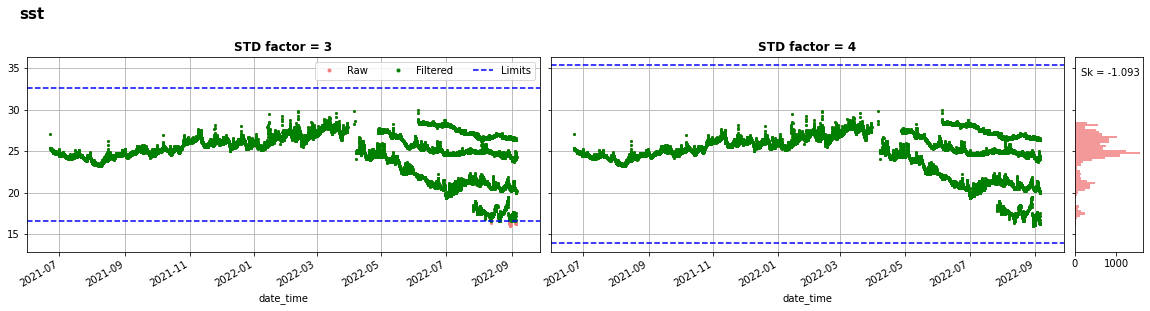

In [21]:
param = 'sst'
plot_comparison(factor1=3, 
                factor2=4, 
                data=spot_gen_lim_data,
                limits=spotters_lims,
                buoy=None,
                parameter=param)

### swvht

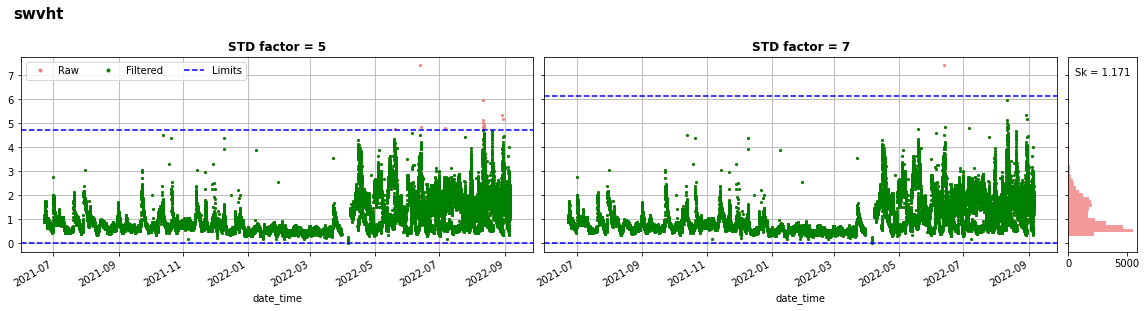

In [22]:
param = 'swvht'
plot_comparison(factor1=5, 
                factor2=7, 
                data=spot_gen_lim_data,
                limits=spotters_lims,
                buoy=None,
                parameter=param)

### tp

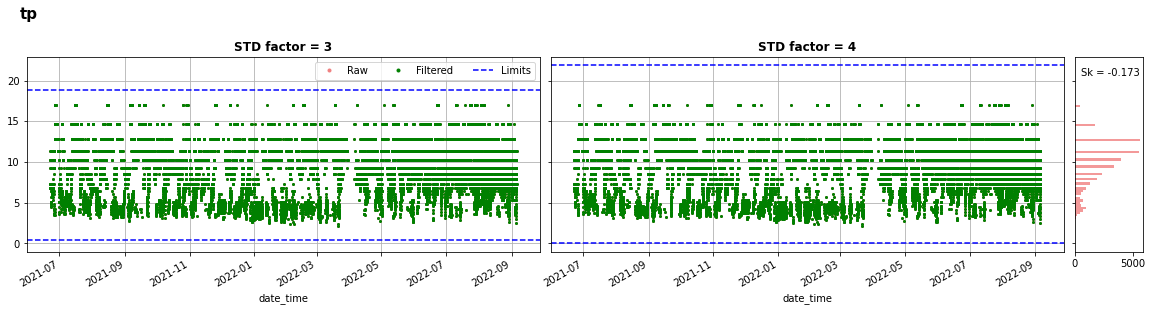

In [23]:
param = 'tp'
plot_comparison(factor1=3, 
                factor2=4, 
                data=spot_gen_lim_data,
                limits=spotters_lims,
                buoy=None,
                parameter=param)

### mean_tp

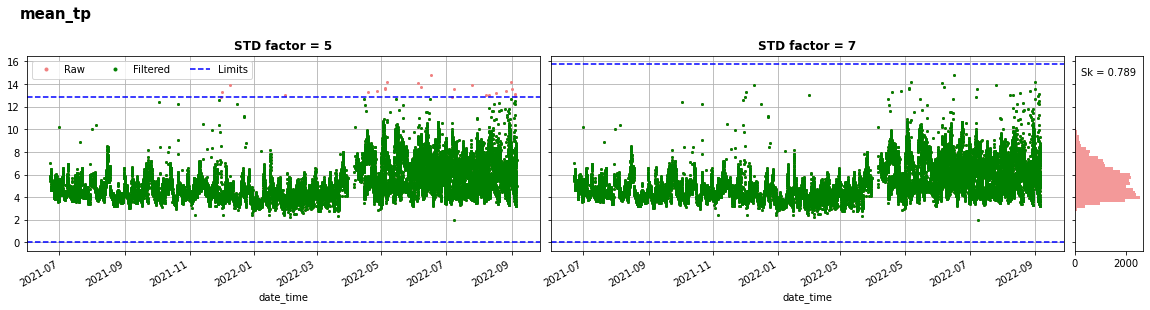

In [24]:
param = 'mean_tp'
plot_comparison(factor1=5, 
                factor2=7, 
                data=spot_gen_lim_data,
                limits=spotters_lims,
                buoy=None,
                parameter=param)

### wspd

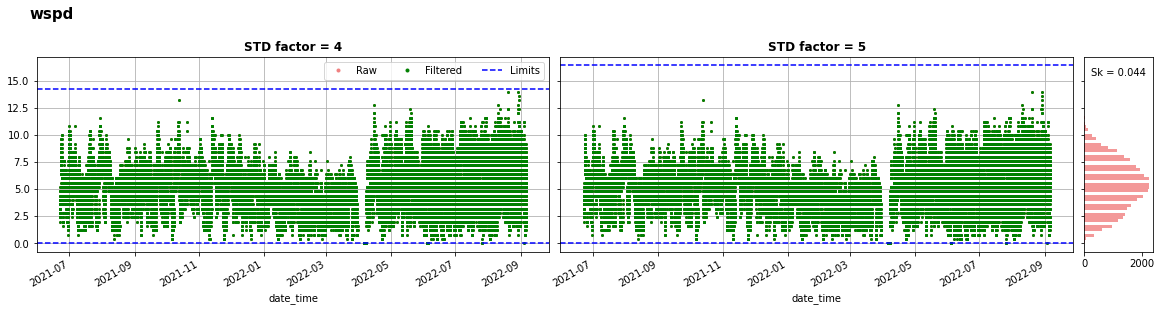

In [25]:
param = 'wspd'
plot_comparison(factor1=4, 
                factor2=5, 
                data=spot_gen_lim_data,
                limits=spotters_lims,
                buoy=None,
                parameter=param)

### Best factor for each parameter
- sst: 4
- swvht: 7
- tp: 3
- mean_tp: 5
- wspd: 5

In [66]:
# FACTOR 3
# Factors per parameter
factors = {'sst': 4, # factor 4
            'tp': 3, # factor 3
            'mean_tp': 5, # factor 5
            'wspd': 5, # factor 5
            'swvht': 7}

# Generated lims
spot_gen_lim_data = spot_filt.drop(columns=['buoy_id','id','lat','lon','sea_surface_id'])
spot_out_lims_df = gen_outlier_lim(data=spot_gen_lim_data,
                                   std_factor=factors).round(1)

# Generate lims dict
spot_out_lims_dict = manual_outlier_lims(spot_out_lims_df.dropna())

In [68]:
spot_out_lims_df

,mean,std,factor,std*factor,lower_lim,upper_lim
param,,,,,,
sst,24.6,2.7,4.0,10.7,13.9,35.4
swvht,1.2,0.7,7.0,4.9,0.0,6.1
tp,9.6,3.1,3.0,9.2,0.4,18.8
mean_tp,5.5,1.5,5.0,7.3,0.0,12.8
pk_dir,155.7,51.7,NaN,NaN,NaN,NaN
wvdir,140.6,51.5,NaN,NaN,NaN,NaN
pk_wvspread,41.6,11.3,NaN,NaN,NaN,NaN
wvspread,56.6,9.8,NaN,NaN,NaN,NaN
wspd,5.3,2.2,5.0,11.1,0.0,16.4


In [67]:
spot_out_lims_dict

{'sst': [13.9, 35.4],
 'swvht': [0.0, 6.1],
 'tp': [0.4, 18.8],
 'mean_tp': [0.0, 12.8],
 'wspd': [0.0, 16.4]}